# FastAPI서버

In [62]:
%%writefile fastApiServer.py
from fastapi import FastAPI, HTTPException, File, UploadFile, Request
from fastapi.middleware.cors import CORSMiddleware
from tensorflow.keras.models import load_model
from fastapi.staticfiles import StaticFiles
from collections import deque
from pydantic import BaseModel
import mediapipe as mp #이거 오류
import tempfile
import shutil
import openai
import numpy as np
import ollama  
import tensorflow as tf
import cv2
import os
import pandas as pd
import joblib
import re
import requests
from chat_functions import *
from fastapi.responses import JSONResponse
from fastapi.exceptions import RequestValidationError
from langchain_openai import ChatOpenAI   # instruct 모델은 OpenAI
from dotenv import load_dotenv
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
load_dotenv()

app= FastAPI()
app
openai.api_key = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini")
llm

LOCAL_DIRECTORY = os.path.join(os.path.dirname(__file__), "fitizenmovie")
app.mount("/videos", StaticFiles(directory=LOCAL_DIRECTORY), name="videos")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # 모든 도메인에서의 요청을 허용하려면 "*" 사용
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# 서버 상태 확인을 위한 기본 엔드포인트
@app.get("/")
def read_root():
    print("VECTOR_STORE_FILE 경로:", VECTOR_STORE_FILE)
    print("벡터 스토어 존재 여부:", os.path.exists(VECTOR_STORE_FILE))
    return {"message": "Welcome to ChatGPT FastAPI!"}

class VideoRequest(BaseModel):
    video_url: str

loaded_lstm_model = load_model('datakeras\\sqaut_model_checkpoint2.keras')  # 모델 경로 설정

@app.post("/analyzevideo")
async def analyze_video(request: VideoRequest):
    try:
        # URL로부터 비디오 스트림 가져오기
        try:
            response = requests.get(request.video_url, stream=True,  verify=False)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Step 2 Error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"비디오 URL 요청 오류: {str(e)}")
        
        # 임시 파일에 비디오 저장
        try:
            with tempfile.NamedTemporaryFile(delete=False, suffix=".mp4") as tmp_file:
                tmp_path = tmp_file.name
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        tmp_file.write(chunk)
        except Exception as e:
            print(f"Step 3 Error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"임시 파일 저장 중 오류 발생: {str(e)}")

        # 비디오 파일을 열어서 프레임별로 처리
        try:
            cap = cv2.VideoCapture(tmp_path)
            print("Downloaded file size:", os.path.getsize(tmp_path))
            if not cap.isOpened():
                raise HTTPException(status_code=500, detail="비디오 파일을 열 수 없습니다.")
        except Exception as e:
            print(f"Step 4 Error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"비디오 파일 열기 오류: {str(e)}")

        # 모델 로드 (경로 확인)
        try:
            loaded_lstm_model
        except Exception as e:
            print(f"Step 5 Error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"LSTM 모델 로드 오류: {str(e)}")
        
        try:
            mp_drawing = mp.solutions.drawing_utils
            mp_pose = mp.solutions.pose
            pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
        except Exception as e:
            print(f"Step 6 Error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"mediapipe pose 초기화 오류: {str(e)}")

         # 분석된 비디오를 저장할 경로 설정
        w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        # 'H264' 또는 'avc1' Ai서버로 올릴시 openh264-1.8.0-win64.dll 다운후 파이썬스크립트에 적용
        fourcc = cv2.VideoWriter_fourcc(*'H264')  
        output_video_path = 'fitizenmovie/processed_' + os.path.basename(tmp_path)
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

        frame_cnt = 0
        sequence_dq = deque(maxlen=30)
        analysis_results = []
        bone_idx = [11, 12, 13, 14, 15, 16, 23, 24, 25, 25, 27, 28]  # 관절 인덱스

        # 비디오 분석 루프
        try:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break  
                frame_cnt += 1

                # 이미지 전처리 및 포즈 추출
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False
                results = pose.process(image)
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)  # 랜드마크 정보를 사용하여 연결선을 그림
                out.write(image)

                if results.pose_landmarks is None:
                    analysis_results.append({"frame": frame_cnt, "prediction": "No landmarks"})
                    continue

                # 관절 위치 데이터 수집
                row = []
                for idx in bone_idx:
                    row.extend([round(results.pose_landmarks.landmark[idx].x, 5),
                                round(results.pose_landmarks.landmark[idx].y, 5)])
                sequence_dq.append(row)

                # 시퀀스 길이가 충분히 쌓였을 때 예측 수행
                if len(sequence_dq) == 30:
                    pred = loaded_lstm_model.predict(np.array(list(sequence_dq)).reshape(1, 30, 24))
                    pred_value = pred[0].argmax()
                    pose_code = str(pred_value)
                    analysis_results.append(f"{frame_cnt}:{pose_code}")
        except Exception as e:
            print(f"Step 7 Error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"비디오 분석 오류: {str(e)}")

        cap.release()
        out.release()
        pose.close()

        # 임시 파일 삭제
        if os.path.exists(tmp_path):
            os.remove(tmp_path)

        ai_server_url = f"{os.path.basename(output_video_path)}"
        
        # return {"frame_count": frame_cnt, "analysis_results": analysis_results}
        analysis_result_str = ",".join(analysis_results)
        aianswer = await analyze_video_ask_chatgpt(analysis_result_str)
        
        return {
            "analysis_results": analysis_result_str,
            "aivideourl": ai_server_url,
            "aianswer": aianswer.get("answer", "응답 없음")
        }

    except Exception as e:
        print(f"알 수 없는 오류 발생: {str(e)}")  # 전체적인 예외 처리
        raise HTTPException(status_code=500, detail=f"알 수 없는 오류 발생: {str(e)}")

async def analyze_video_ask_chatgpt(question_str: str):
    try:
        # 벡터 스토어 초기화
        vector_store = get_or_create_vector_store()

        # 관련 문서 검색
        relevant_docs = search_relevant_docs(vector_store, question_str)

        # 관련 문서를 하나의 텍스트로 합치기
        relevant_texts = " ".join([doc.page_content for doc in relevant_docs])

        # GPT 프롬프트 생성
        gpt_prompt = (
            f"다음 스쿼트 자세 프레임 데이터를 분석하고 피드백을 제공하세요.\n\n"
            f"프레임 데이터: {question_str}\n\n"
            "자세 값:\n"
            "  0: 올바른 자세.\n"
            "  1: 무릎 문제 (예: 무릎이 안쪽으로 움직이거나, 발끝을 초과함).\n"
            "  2: 깊이 문제 (예: 너무 얕거나 너무 깊음).\n"
            "  3: 허리 각도 문제 (예: 둥글거나 과도하게 펴짐).\n\n"
            "규칙:\n"
            "- 반드시 한국어로만 작성하세요. 영어로 응답하지 마세요.\n"
            "- 제공된 프레임 데이터에 없는 자세 값에 대해서는 피드백을 작성하지 마세요.\n"
            "- 특정 자세 값이 많은 경우 해당 문제에 대한 피드백에 집중하세요.\n"
            "- 여러 자세 값이 섞여 있는 경우, 각 유형별로 제공된 프레임 데이터에 있는 자세 값에 대해 분석하고 피드백을 작성하세요.\n"
            "- 프레임 데이터 갯수를 정확하게 작성하세요.\n"
            "- 문제를 요약하고, 해결 방법을 제안하세요.\n\n"
            "분석 결과를 아래에 한국어로만 작성하세요:"
        )

        # GPT 모델 호출
        gpt_response = llm.invoke(gpt_prompt)

        # 응답에서 내용을 추출
        answer = gpt_response.content

        # 결과 반환
        return {"answer": answer}
    except Exception as e:
        print(f"Error in analyze_video_ask_chatgpt: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# 전처리기 및 모델 로드
preprocessor = joblib.load("preprocessor.pkl")
model = tf.keras.models.load_model("exercise_recommendation_model.keras")

# 운동 클래스 라벨
class_labels = ["badminton", "basketball", "cardio", "health", "pilates", "swimming", "tabletennis", "yoga"]


# 입력 데이터 형식을 정의하는 Pydantic 모델
class ExerciseInput(BaseModel):
    height: int
    weight: int
    goal: str
    frequency: str
    preference: str

# 예측 엔드포인트
@app.post("/predict_exercise")
async def predict_exercise(input_data: ExerciseInput):
    # 입력 데이터를 DataFrame으로 변환
    input_df = pd.DataFrame([input_data.dict()])
    print("Received input data:", input_data)
    
    # 전처리
    try:
        processed_data = preprocessor.transform(input_df)
    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Data preprocessing error: {e}")

    # 모델 예측 수행
    try:
        predictions = model.predict(processed_data)[0]  # 첫 번째 예측 결과만 사용
        top_indices = np.argsort(predictions)[-3:][::-1]  # 상위 3개 인덱스를 높은 순으로 정렬

        # 추천된 운동과 정확도 추출
        recommended_exercises = [class_labels[i] for i in top_indices]
        confidence_scores = [predictions[i] for i in top_indices]
        
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Model prediction error: {e}")

    # 예측 결과와 정확도 반환
    return {
 "recommended_exercise1": recommended_exercises[0],
        "recommended_exercise2": recommended_exercises[1],
        "recommended_exercise3": recommended_exercises[2],
        "confidence_score1": round(float(confidence_scores[0]*100), 2),
        "confidence_score2": round(float(confidence_scores[1]*100), 2),
        "confidence_score3": round(float(confidence_scores[2]*100), 2)
    }

# 요청 바디 모델 정의
class QuestionRequest(BaseModel):
    question: str

VECTOR_STORE_FILE = "vector_store.faiss"
PDF_FILE = "test.pdf"

# 벡터 스토어 생성 함수
def create_vector_store_from_pdf(pdf_file):
    try:
        loader = PyPDFLoader(pdf_file)
        documents = loader.load()
        print(f"Loaded {len(documents)} documents from PDF.")
    except Exception as e:
        print(f"Error while loading PDF file: {e}")
        raise HTTPException(status_code=500, detail=f"PDF 파일을 로드할 수 없습니다: {e}")

    try:
        text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=0)
        docs = text_splitter.split_documents(documents)
        print(f"Split into {len(docs)} document chunks.")
    except Exception as e:
        print(f"Error while splitting documents: {e}")
        raise HTTPException(status_code=500, detail=f"문서 청크 처리 중 오류 발생: {e}")

    try:
        embeddings = OpenAIEmbeddings()
        vector_store = FAISS.from_documents(docs, embeddings)
        return vector_store
    except Exception as e:
        print(f"Error while creating vector store: {e}")
        raise HTTPException(status_code=500, detail=f"벡터 스토어 생성 중 오류 발생: {e}")


# 벡터 스토어 저장 함수
def save_vector_store(vector_store, file_path):
    vector_store.save_local(file_path)

# 벡터 스토어 로드 함수
def load_vector_store(file_path):
    embeddings = OpenAIEmbeddings()
    return FAISS.load_local(file_path, embeddings, allow_dangerous_deserialization=True)

# 사용자의 질문(query)과 유사한 문서를 검색
def search_relevant_docs(vector_store, query):
    embeddings = OpenAIEmbeddings()
    query_embedding = embeddings.embed_query(query)
    results = vector_store.similarity_search_by_vector(query_embedding, k=3)
    return results

# ChatGPT API 호출 함수 (검색된 문서에 기반한 답변 생성)
def call_chatgpt_api(prompt):
    response = openai.Completion.create(
        model="gpt-4o-mini",  # 사용할 GPT 모델
        prompt=prompt,
        max_tokens=100
    )
    return response.choices[0].text.strip()
def get_or_create_vector_store():
    if os.path.exists(VECTOR_STORE_FILE):
        print("저장된 벡터 스토어를 로드합니다...")
        return load_vector_store(VECTOR_STORE_FILE)
    else:
        print("벡터 스토어가 없습니다. PDF에서 생성 중...")
        vector_store = create_vector_store_from_pdf(PDF_FILE)
        save_vector_store(vector_store, VECTOR_STORE_FILE)
        print("벡터 스토어가 생성되고 저장되었습니다.")
        return vector_store    

# 질문을 받아서 OpenAI API에 요청하는 엔드포인트
@app.post("/ask")
async def ask_chatgpt(request: Request):
    try:
        body = await request.json()
        raw_body = await request.body()  # 요청 본문 출력
    except Exception as e:
        raise HTTPException(status_code=400, detail="Invalid JSON provided")
    
    question = body.get("question")
    if not question:
        raise HTTPException(status_code=400, detail="No question provided")
    
    vector_store = get_or_create_vector_store()
    relevant_docs = search_relevant_docs(vector_store, question)
    relevant_texts = " ".join([doc.page_content for doc in relevant_docs])
    gpt_prompt = (
    f"Based on the following documents, answer the question: {question}\n\nDocuments:\n{relevant_texts}\n\n"
    "If the question is not related to the content of the document, "
    "please respond with: 'I'm unable to provide an answer.'\n"
    "If there is a URL in the response, display it on the last line."
    )
    gpt_response = llm.invoke(gpt_prompt)
    answer = gpt_response.content  # content 부분만 추출

    try:
        return {"answer": answer}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.exception_handler(RequestValidationError)
async def validation_exception_handler(request, exc):
    return JSONResponse(
        status_code=422,
        content={"detail": exc.errors(), "body": exc.body},
    )

# 올라마 API 요청 엔드포인트
@app.post("/ask2")
async def ask_ollama(request: QuestionRequest):
    question = request.question
    if not question:
        raise HTTPException(status_code=400, detail="No question provided")

    try:
        # Ollama API에 프롬프트 전달
        response = ollama.chat(
            model="unsloth.Q8_0.gguf",
            messages=[{"role": "user", "content": ollama_prompt}]
        )
        
        # 응답에서 답변 추출
        answer = response['message']['content']
        return {"answer": answer}
        
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

# FastAPI 앱 실행을 위한 코드
if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="127.0.0.1", port=8000)

Overwriting fastApiServer.py


Epoch 1/100
250/250 [==============================] - 4s 6ms/step - loss: 4.6270 - accuracy: 0.2159 - val_loss: 4.3119 - val_accuracy: 0.3670
Epoch 2/100
250/250 [==============================] - 1s 5ms/step - loss: 4.0543 - accuracy: 0.3494 - val_loss: 3.7472 - val_accuracy: 0.4250
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 3.5212 - accuracy: 0.4615 - val_loss: 3.1997 - val_accuracy: 0.5865
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 3.0221 - accuracy: 0.5710 - val_loss: 2.7099 - val_accuracy: 0.6465
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 2.5982 - accuracy: 0.6575 - val_loss: 2.3099 - val_accuracy: 0.7535
Epoch 6/100
250/250 [==============================] - 1s 4ms/step - loss: 2.2567 - accuracy: 0.7433 - val_loss: 1.9924 - val_accuracy: 0.8925
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 1.9848 - accuracy: 0.8190 - val_loss: 1.7492 - val_accuracy: 0.9125

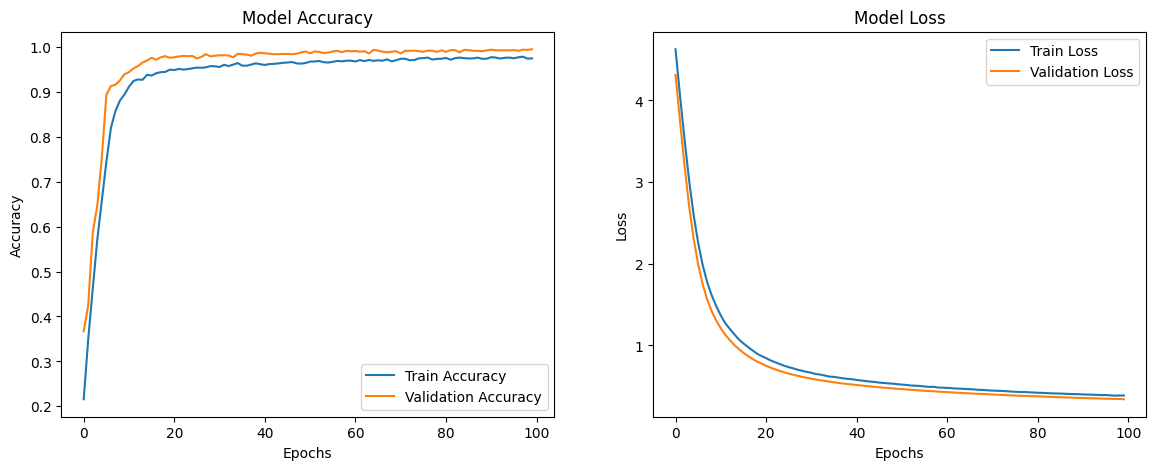

63/63 [==============================] - 0s 4ms/step - loss: 0.3419 - accuracy: 0.9945
Test Accuracy: 0.9945
1/1 [==============================] - 0s 145ms/step
Recommended Exercise: badminton


In [94]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from collections import Counter

# 1. 데이터 로드 및 전처리 (원본 데이터 사용)
data = pd.read_csv('conditional_exercise_data.csv')  # 파일 경로에 맞춰 수정하세요

# 2. 특성 및 타겟 분리
X = data.drop(columns=['recommended_exercise'])
y = data['recommended_exercise']

# 3. 타겟 레이블 인코딩
y_encoded = pd.get_dummies(y)  # 원-핫 인코딩

# 4. 데이터 전처리기 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['height', 'weight']),
        ('cat', OneHotEncoder(), ['goal', 'frequency', 'preference'])
    ])

# 5. 전처리기 적용
X_processed = preprocessor.fit_transform(X)

# 6. 훈련/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded.values, test_size=0.2, random_state=42, stratify=y
)

# 7. 모델 정의 함수
def create_model(learning_rate=0.00005, dropout_rate=0.2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 8. 모델 초기화 및 조기 종료 콜백 설정
final_model = create_model(learning_rate=0.00005, dropout_rate=0.2)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 9. 모델 학습 (클래스 가중치 제거)
history = final_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# 10. 학습 및 검증 결과 시각화
# 정확도 그래프
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 11. 최종 평가
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# 12. 예측 예시
sample_input = np.array([X_test[0]])  # 예시 입력
predicted_class = final_model.predict(sample_input)
predicted_label = y_encoded.columns[np.argmax(predicted_class)]
print(f"Recommended Exercise: {predicted_label}")


In [95]:
final_model.save('exercise_recommendation_model.keras')
print("모델이 .keras 형식으로 성공적으로 저장되었습니다.")

모델이 .keras 형식으로 성공적으로 저장되었습니다.


In [55]:
from tensorflow.keras.models import load_model
loaded_lstm_model = load_model('datakeras/sqaut_model_checkpoint2.keras')  # 모델 경로 설정
loaded_lstm_model

In [27]:
pip show mediapipe

Name: mediapipe
Version: 0.10.13
Summary: MediaPipe is the simplest way for researchers and developers to build world-class ML solutions and applications for mobile, edge, cloud and the web.
Home-page: https://github.com/google/mediapipe
Author: The MediaPipe Authors
Author-email: mediapipe@google.com
License: Apache 2.0
Location: c:\users\basicuser\anaconda3\envs\pytorch_env\lib\site-packages
Requires: absl-py, attrs, flatbuffers, jax, jaxlib, matplotlib, numpy, opencv-contrib-python, protobuf, sounddevice
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [28]:
pip show protobuf

Name: protobufNote: you may need to restart the kernel to use updated packages.

Version: 3.19.6
Summary: Protocol Buffers
Home-page: https://developers.google.com/protocol-buffers/
Author: 
Author-email: 
License: 3-Clause BSD License
Location: c:\users\basicuser\anaconda3\envs\pytorch_env\lib\site-packages
Requires: 
Required-by: mediapipe, tensorboard, tensorflow


In [29]:
pip show tenserflow

Note: you may need to restart the kernel to use updated packages.


In [47]:
import mediapipe as mp
mp_pose = mp.solutions.pose
print("mediapipe pose 모듈이 정상적으로 로드되었습니다.")

mediapipe pose 모듈이 정상적으로 로드되었습니다.


In [ ]:
import cv2
print(cv2.getBuildInformation())

In [102]:
import os
print(os.getcwd())

C:\Users\BasicUser\AiClassFile
